In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import seedlib.main as sl
from trackml.dataset import load_event
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input/train_1/"))

#hits, cells, particles, truth = load_event('event000001749')


# Any results you write to the current directory are saved as output.

In [2]:
# Parameters
#hit_join = pd.merge(hits, truth, on='hit_id')
#particle_join = pd.merge(hit_join, particles, on='particle_id')
#sorted_particle_join = particle_join.sort_values(by='particle_id')
#particle_data = particle_join[['x', 'y', 'z', 'particle_id', 'tx', 'ty', 'tz', 'tpx', 'tpy', 'tpz', 'q', 'vx', 'vy', 'vz', 'px', 'py', 'pz']]
#grouped_particles = particle_data.groupby('particle_id')
#for name, group in grouped_particles:
#    print(group)
#    break
#display(particle_data.head())
##N, D_in, H, D_out = 64, 1000, 100, 10


In [4]:
class ParticleDataset(Dataset):

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        hits, cells, particles, truth = load_event(csv_file)
        hit_join = pd.merge(hits, truth, on='hit_id')
        particle_join = pd.merge(hit_join, particles, on='particle_id')
        self.particle_data = particle_join[['x', 'y', 'z', 'particle_id', 'tx', 'ty', 'tz', 'tpx', 'tpy', 'tpz', 'q', 'vx', 'vy', 'vz', 'px', 'py', 'pz']]
        self.grouped_particles = self.particle_data.groupby('particle_id')

    def __len__(self):
        return len(self.grouped_particles)
    
    def get_random_sample(self):
        key = np.random.choice(self.particle_data.particle_id.unique())
        return self.particle_data[self.particle_data['particle_id'] == key]

    def __getitem__(self, idx):
        return self.particle_data[self.particle_data['particle_id'] == idx]

In [5]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)
        '''
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.relu = nn.ReLU()
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        '''

    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:

pd.options.mode.chained_assignment = None
def generate_input_target(input):
    inp = input[['tx', 'ty', 'tz', 'tpx', 'tpy', 'tpz']]
    inp.loc[-1] = input.loc[0][['vx', 'vy', 'vz', 'px', 'py', 'pz']].values
    inp.index = inp.index + 1  # shifting index
    inp.sort_index(inplace=True)
    target = inp[1:]
    inp = inp[:-1]
    inp, target = inp.values, target.values
    return torch.from_numpy(inp[None, :]).float(), torch.from_numpy(target[None, :]).float()



#print(nparticle.columns)
#x, y = generate_input_target(nparticle)
    

In [7]:
loss_func = nn.MSELoss()
rnn = RNN()
LR = 0.00002 # learning rate
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
import ipdb

def train(input_line_tensor, target_line_tensor, h_state):
    #target_line_tensor.unsqueeze_(-1)
    hidden = None
    #print(input_line_tensor, target_line_tensor)
    prediction, h_state = rnn(input_line_tensor, h_state)   # rnn output
    # !! next step is important !!
    h_state = h_state.data        # repack the hidden state, break the connection from last iteration

    loss = loss_func(prediction, target_line_tensor)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients
    return prediction, h_state, loss

'''
    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        inp_line = input_line_tensor[i]
        inp_line = inp_line.unsqueeze(0).float()
        target_line = target_line_tensor[i].unsqueeze(0).float()
        output, hidden = rnn(inp_line, hidden.float())
        l = criterion(output, target_line)
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    #print(loss.item())
    #print(input_line_tensor.size(0))
    return output, loss.item() / input_line_tensor.size(0)
'''


'\n    rnn.zero_grad()\n\n    loss = 0\n\n    for i in range(input_line_tensor.size(0)):\n        inp_line = input_line_tensor[i]\n        inp_line = inp_line.unsqueeze(0).float()\n        target_line = target_line_tensor[i].unsqueeze(0).float()\n        output, hidden = rnn(inp_line, hidden.float())\n        l = criterion(output, target_line)\n        loss += l\n\n    loss.backward()\n\n    for p in rnn.parameters():\n        p.data.add_(-learning_rate, p.grad.data)\n    #print(loss.item())\n    #print(input_line_tensor.size(0))\n    return output, loss.item() / input_line_tensor.size(0)\n'

In [8]:
events = set()
for file in os.listdir('./input/'):
    spl = file.split('-')
    events.add(spl[0])
#print(events)

In [9]:
checkpoint = torch.load('./current_checkpoint')
rnn.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']


In [ ]:
%matplotlib notebook
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
def save_checkpoint(state, filename='./current_checkpoint'):
    if os.path.isfile(filename):
        os.remove(filename)
    torch.save(state, filename)


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()



start = time.time()
h_state = None
for event in events:
    particles = ParticleDataset('./input/' + event)
    for iter in range(1, n_iters + 1):
        nparticle = particles.get_random_sample()
        nparticle = nparticle.reset_index()
        input, target = generate_input_target(nparticle)
        #x = input.split(2)
        inps = torch.split(input, 1, 2)
        targs = torch.split(target, 1, 2)
        for inp, tar in zip(inps, targs):
            output, h_state, loss = train(inp, tar, h_state)
            current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, current_loss / plot_every))

        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            ax.clear()
            ax.plot(all_losses)
            fig.canvas.draw()
            
    epoch += 1
    save_checkpoint({
    'epoch': (epoch + 1),
    'state_dict': rnn.state_dict(),
    'optimizer': optimizer.state_dict(),
    })


<IPython.core.display.Javascript object>

1m 26s (5000 5%) 906975.7500
2m 52s (10000 10%) 941271.0000
4m 19s (15000 15%) 849436.7500
5m 44s (20000 20%) 836316.6875
7m 8s (25000 25%) 808370.7500


In [ ]:
print(rnn.i2h.weight.grad)

[tensor(1.00000e+06 *
       1.0575), tensor(1.00000e+05 *
       7.8361), tensor(1.00000e+05 *
       7.5889), tensor(1.00000e+05 *
       6.7351), tensor(1.00000e+05 *
       6.8868), tensor(1.00000e+05 *
       6.3650), tensor(1.00000e+05 *
       6.1816), tensor(1.00000e+05 *
       6.2358), tensor(1.00000e+05 *
       6.0049), tensor(1.00000e+05 *
       5.9386), tensor(1.00000e+05 *
       5.8802), tensor(1.00000e+05 *
       5.8686), tensor(5.8637e+05), tensor(1.00000e+05 *
       5.9663), tensor(1.00000e+05 *
       5.9952), tensor(1.00000e+05 *
       5.9765), tensor(1.00000e+05 *
       5.9855), tensor(1.00000e+05 *
       5.9710), tensor(1.00000e+05 *
       5.9695), tensor(1.00000e+05 *
       5.9687), tensor(1.00000e+05 *
       5.9682), tensor(1.00000e+05 *
       5.9679), tensor(1.00000e+05 *
       5.9677), tensor(1.00000e+05 *
       5.9675), tensor(1.00000e+05 *
       5.9675), tensor(1.00000e+05 *
       5.9675), tensor(1.00000e+05 *
       5.9675), tensor(1.00000e+0

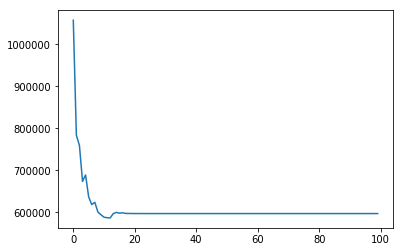

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
print(all_losses)
